# GRACE & GRACE FO downscaling project


<font color='Cyan'>This s a notebok for downscaling GRACE data using ERA5. Downscaling is done using XGBoost or Random Forest models.</font>


<font size="2">To run this notebook, first install the required packages as described in the README_notebook.md file. It is recomended to create a virtual environment and install the packages there. 
It is also recomended to create a similar folder structure as the one in the README_notebook.md file.</font>

<font size="2">Download ERA5 data. To do so follow first instructions from https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Windows. If you are using a different OS, follow instructions from https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Linux+or+Mac. You can see details on the ERA5 variables at https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download. Please have in mind that if you want to use a different variable, you need to modify the backend_notebook.ipynb file.</font>

# <font size="4"> Import dependencies </font>

In [1]:
import cdsapi
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
import xgboost as xgb
import joblib
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# <font size="4"> ERA5 Data Download </font>

In [ ]:
#Download ERA5 data from the Copernicus Data Store API
import cdsapi

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "2m_temperature",
        "total_precipitation",
        "evaporation",
        "potential_evaporation",
        "sub_surface_runoff",
        "surface_runoff",
        "soil_type",
        "volumetric_soil_water_layer_1",
        "volumetric_soil_water_layer_2",
        "volumetric_soil_water_layer_3",
        "volumetric_soil_water_layer_4",
        "leaf_area_index_high_vegetation",
        "leaf_area_index_low_vegetation"
    ],
    "year": [
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020", "2021", "2022",
        "2023", "2024", "2025"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


# <font size="4"> Import datasets</font>

In [2]:
#Import datasets
CSR_path  = "../data/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-corrections.nc"
ERA_path1 = "../data/data_stream-moda_stepType-avgad.nc"
ERA_path2 = "../data/data_stream-moda_stepType-avgua.nc"

In [3]:
# read-print dataset
ds = xr.open_dataset(CSR_path)
ds_era1 = xr.open_dataset(ERA_path1)
ds_era2 = xr.open_dataset(ERA_path2)
# print(ds.head())
# print(ds_era1.head())
# print(ds_era2.head())

# <font size="4"> Data Slicing to Region of Interest </font>

In [4]:
# Data slicing to Area of Interest

print("Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]")
try:
    lat_min = float(input("Latitude Min : "))
    lat_max = float(input("Latitude Max : "))
    lon_min = float(input("Longitude Min : "))
    lon_max = float(input("Longitude Max : "))
except ValueError:
    print("Wrong input! Please insert a number!")
print(f"\nArea of Interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}]")

# Slice function
def slice_nc(ds, ds_name):
    print(f"\nSlicing {ds_name}")

    possible_lat_names = ['lat', 'latitude']
    possible_lon_names = ['lon', 'longitude']
    
    lat_name = None
    lon_name = None

    print("Checking for possible lat/lon names ")
    for name in ds.coords:
        # Checking with .lower() for possible lat/lon names
        if name.lower() in possible_lat_names:
            lat_name = name
        elif name.lower() in possible_lon_names:
            lon_name = name
    
    if not lat_name or not lon_name:
        raise ValueError(f" ERROR: There are no lat/lon columns in {ds_name}")

    # Converting Longitude (0-360 -> -180,180) ---
    if ds[lon_name].max() > 180:
        print(" Converting Longitude in -180,180")
        ds = ds.assign_coords({lon_name: (((ds[lon_name] + 180) % 360) - 180)})
    ds = ds.sortby(lon_name)

    # Check convertion
    lat_values = ds[lat_name].values  
    # Sorting
    if lat_values[0] > lat_values[-1]: 
        lat_slice = slice(lat_max, lat_min)
    else:
        lat_slice = slice(lat_min, lat_max)

    # Final slice to Area of Interest
    ds_sliced = ds.sel({
        lat_name: lat_slice, 
        lon_name: slice(lon_min, lon_max)
    })
    return ds_sliced

ds_grace_sliced = slice_nc(ds, "GRACE")
ds_era1_sliced = slice_nc(ds_era1, "ERA5_1")
ds_era2_sliced = slice_nc(ds_era2,"ERA5_2")
print(f"\nCreated a data slice to the Arae of Interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}] ")

Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]

Area of Interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0]

Slicing GRACE
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Slicing ERA5_1
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Slicing ERA5_2
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Created a data slice to the Arae of Interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0] 


# <font size="4"> Create year, month columns for data alignment </font>

In [5]:
# Fixing the time variable in GRACE data: exporting year and month from timestamp
ds = ds_grace_sliced
ds["time"] = pd.to_datetime(
    ds.time.values, origin="2002-01-01", unit="D"
)

# Drop time_bounds column, if it exists
ds = ds.drop_vars("time_bounds", errors="ignore")
print(ds)

# Convert xarray dataset to pandas dataframe
ds = ds_grace_sliced
grace_df = ds.to_dataframe().reset_index()
print(grace_df.head())

# Add year and month columns to the dataframe
grace_df["year"] = grace_df["time"].dt.year
grace_df["month"] = grace_df["time"].dt.month
print(grace_df.head()) 

<xarray.Dataset> Size: 10MB
Dimensions:        (time: 248, lat: 88, lon: 120)
Coordinates:
  * time           (time) datetime64[ns] 2kB 2002-04-18 ... 2025-08-16T12:00:00
  * lat            (lat) float32 352B -16.88 -16.62 -16.38 ... 4.375 4.625 4.875
  * lon            (lon) float32 480B -79.88 -79.62 -79.38 ... -50.38 -50.12
Data variables:
    lwe_thickness  (time, lat, lon) float32 10MB ...
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    filename:                   netcdf/CSR_GRACE_GRACE-FO_RL0603_Mascons_all-...
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      CSR GRACE and GRACE-FO MASCON RL0603M
    subtitle:                   RL06.3 GRACE/GRACE-FO Total water storage wit...
    ...                         ...
    user_note_3:                Ellipsoidal correction has been applied. The ...
    user_note_4:              

In [6]:
# Convert ERA5 data to DataFrames
ds_era1 = ds_era1_sliced
ds_era2 = ds_era2_sliced
era5_df1 = ds_era1.to_dataframe().reset_index()
era5_df2 = ds_era2.to_dataframe().reset_index()

# Fix the time variable in ERA5 data: exporting year and month from timestamp
era5_df1["year"] = era5_df1["valid_time"].dt.year
era5_df1["month"] = era5_df1["valid_time"].dt.month
era5_df2["year"] = era5_df2["valid_time"].dt.year
era5_df2["month"] = era5_df2["valid_time"].dt.month

# Rename longitude and latitude columns for data alignment
era5_df1 = era5_df1.rename(columns={"longitude": "lon", "latitude": "lat"})
era5_df2 = era5_df2.rename(columns={"longitude": "lon", "latitude": "lat"})

print(era5_df1.head())
print(era5_df2.head())

           valid_time  lat    lon        tp         e           pev  ssro  \
0 2002-01-01 06:00:00  5.0 -80.00  0.008549 -0.002826  7.450581e-08   0.0   
1 2002-01-01 06:00:00  5.0 -79.75  0.010048 -0.002742  7.450581e-08   0.0   
2 2002-01-01 06:00:00  5.0 -79.50  0.011562 -0.002648  7.450581e-08   0.0   
3 2002-01-01 06:00:00  5.0 -79.25  0.012827 -0.002535  7.450581e-08   0.0   
4 2002-01-01 06:00:00  5.0 -79.00  0.014244 -0.002271  7.450581e-08   0.0   

   sro  number expver  year  month  
0  0.0       0   0001  2002      1  
1  0.0       0   0001  2002      1  
2  0.0       0   0001  2002      1  
3  0.0       0   0001  2002      1  
4  0.0       0   0001  2002      1  
  valid_time  lat    lon         t2m  slt     swvl1     swvl2     swvl3  \
0 2002-01-01  5.0 -80.00  299.309570  0.0  0.000004  0.000003  0.000001   
1 2002-01-01  5.0 -79.75  299.254883  0.0  0.000004  0.000003  0.000001   
2 2002-01-01  5.0 -79.50  299.211914  0.0  0.000004  0.000003  0.000001   
3 2002-01-01  5

# <font size="4"> Merge ERA5 and GRACE datasets => Create training dataset </font>

In [7]:
# Merge the ERA5 dataframes on lon, lat, year, month

era5_df = pd.merge(
    era5_df1,
    era5_df2,
    on=[ "lon", "lat", "year", "month"],
    how="inner"
)
era5_df2=era5_df.drop(columns=['valid_time_y', 'valid_time_x', 'number_x', 'number_y', 'expver_x', 'expver_y'])
print(era5_df2.head())

   lat    lon        tp         e           pev  ssro  sro  year  month  \
0  5.0 -80.00  0.008549 -0.002826  7.450581e-08   0.0  0.0  2002      1   
1  5.0 -79.75  0.010048 -0.002742  7.450581e-08   0.0  0.0  2002      1   
2  5.0 -79.50  0.011562 -0.002648  7.450581e-08   0.0  0.0  2002      1   
3  5.0 -79.25  0.012827 -0.002535  7.450581e-08   0.0  0.0  2002      1   
4  5.0 -79.00  0.014244 -0.002271  7.450581e-08   0.0  0.0  2002      1   

          t2m  slt     swvl1     swvl2     swvl3         swvl4  lai_hv  lai_lv  
0  299.309570  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
1  299.254883  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
2  299.211914  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
3  299.202148  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  
4  299.198242  0.0  0.000004  0.000003  0.000001 -3.557767e-26     0.0     0.0  


In [8]:
# Compute GRACE resolution

g_lats = np.sort(grace_df["lat"].unique()) # .unique(): Πετάει τα διπλά δεδομένα
g_lons = np.sort(grace_df["lon"].unique())

dlat = np.diff(g_lats)
dlon = np.diff(g_lons)

step_lat = dlat[dlat > 0].min()
step_lon = dlon[dlon > 0].min()

step = float(min(step_lat, step_lon))
print("GRACE resolution ~", step, "degrees")

GRACE resolution ~ 0.25 degrees


In [9]:
# Regrid the merged ERA5 dataframe to match the grace_df grid (use step variable from the cell above)

grace_df["lat_r"] = (grace_df["lat"] / step).round() * step
grace_df["lon_r"] = (grace_df["lon"] / step).round() * step

era5_df2["lat_r"] = (era5_df2["lat"] / step).round() * step
era5_df2["lon_r"] = (era5_df2["lon"] / step).round() * step
print(grace_df.head())
print(era5_df2.head())

        time  timebound     lat     lon  time_bounds  lwe_thickness  year  \
0 2002-04-18          0 -16.875 -79.875         94.0      -0.473648  2002   
1 2002-04-18          0 -16.875 -79.625         94.0      -0.473648  2002   
2 2002-04-18          0 -16.875 -79.375         94.0      -0.141746  2002   
3 2002-04-18          0 -16.875 -79.125         94.0      -0.141746  2002   
4 2002-04-18          0 -16.875 -78.875         94.0      -0.141746  2002   

   month  lat_r  lon_r  
0      4  -17.0  -80.0  
1      4  -17.0  -79.5  
2      4  -17.0  -79.5  
3      4  -17.0  -79.0  
4      4  -17.0  -79.0  
   lat    lon        tp         e           pev  ssro  sro  year  month  \
0  5.0 -80.00  0.008549 -0.002826  7.450581e-08   0.0  0.0  2002      1   
1  5.0 -79.75  0.010048 -0.002742  7.450581e-08   0.0  0.0  2002      1   
2  5.0 -79.50  0.011562 -0.002648  7.450581e-08   0.0  0.0  2002      1   
3  5.0 -79.25  0.012827 -0.002535  7.450581e-08   0.0  0.0  2002      1   
4  5.0 -79.0

In [10]:
# Final merge of GRACE and ERA5 datasets
# Merged dataframe is going to be used for training the model

merged = pd.merge(
    grace_df,
    era5_df2,
    on=["year", "month", "lat_r", "lon_r"],
    how="inner",
    suffixes=("_grace", "_era")
)
#print(merged.head())

# Remove rows with year 2025 and above. Training is going to be done up to 2024. 
# 2025 and on is going to be used for testing

merged= merged[merged['year'] <= 2024]
print(f"Most recent year in training dataset: {merged['year'].max()}")

data_out = ['time','lat_r','lat_era','lon_r','lon_era']
merged = merged.drop(columns = data_out, errors='ignore')

print(merged.tail())

Most recent year in training dataset: 2024
         timebound  lat_grace  lon_grace  time_bounds  lwe_thickness  year  \
5068795          1      4.875    -51.125       8401.0       0.516883  2024   
5068796          1      4.875    -50.875       8401.0      -0.308139  2024   
5068797          1      4.875    -50.625       8401.0      -0.308139  2024   
5068798          1      4.875    -50.375       8401.0      -0.308139  2024   
5068799          1      4.875    -50.125       8401.0       0.947064  2024   

         month        tp         e           pev  ssro  sro         t2m  slt  \
5068795     12  0.006504 -0.004061  1.043081e-07   0.0  0.0  299.793457  0.0   
5068796     12  0.006504 -0.004061  1.043081e-07   0.0  0.0  299.793457  0.0   
5068797     12  0.006441 -0.004221  1.043081e-07   0.0  0.0  299.838379  0.0   
5068798     12  0.006441 -0.004221  1.043081e-07   0.0  0.0  299.838379  0.0   
5068799     12  0.007189 -0.004519  1.043081e-07   0.0  0.0  299.891113  0.0   

       

# <font size="4"> Choose model, Do RFE and train the ERA5 data on GRACE data </font>

In [11]:
# Choose the model
print("Choose the model you want to use: (XGBoost/RF)")
try:
    model_used = (input("Choose ML model (XGBoost/RF): "))
except ValueError:
    print("Error! Please enter 'XGBoost' or 'RF'.")
print(f"The prediction will be made with the model {model_used}")

# Drop NaN values
df_clean = merged.dropna()
y = df_clean["lwe_thickness"]

if model_used == "XGBoost":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','slt','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=50, random_state=42, n_jobs=-1)

elif model_used == "RF":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','slt','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
else:
    print("Invalid model input!")
    print("Please enter 'XGBoost' or 'RF'.")
# Choose the number of features you want to select for the RFE
print("Choose the number of features you want to select")
try: 
    n_features_to_select = int(input("Insert the number of features you want to select : ")) 
    print(f"The RFE will be performed with: {n_features_to_select} features")
except ValueError:
    print("Invalid input!")
    sys.exit()

# RFE Classification
rfe = RFE(estimator=model, n_features_to_select= n_features_to_select) 

rfe.fit(x, y)

# Print selected features from RFE
selected_features = x.columns[rfe.support_].tolist()

print("\n RFE Results!")
print(f" Τα {n_features_to_select} Best Features are:")
print(selected_features)

Choose the model you want to use: (XGBoost/RF)
The prediction will be made with the model XGBoost
Features included in training: ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'pev', 't2m', 'slt', 'lai_hv', 'lai_lv']
Choose the number of features you want to select
The RFE will be performed with: 5 features

 RFE Results!
 Τα 5 Best Features are:
['tp', 'ssro', 'swvl4', 't2m', 'slt']


In [ ]:
# Model training and export
# Create array with selected features
x_final = x[selected_features]
print(f"Training will use: \n {x_final.head(1)}")
target = "lwe_thickness"
extra_features = ["year", "month", "lon_grace", "lat_grace"]
base_features = list(x_final.columns)
# Final feature list
features = base_features + extra_features
features = [col for col in features if col != target]
# Define X and y
X = merged[features]
y = merged[target]

# Split into training and validation datasets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    x_final, y,
    test_size=0.2,
    random_state=42
)

if model_used == "XGBoost":
    print("  XGBoost Tuning...")
    param_grid = {
    'n_estimators': [100, 200, 500], #500
    'max_depth': [10, 20, 6], 
    'colsample_bytree': [0.7, 0.8, 1], #0.7,0.8,1
    'min_child_weight': [1, 3, 5], 
    'learning_rate': [0.01, 0.05, 0.1] #0.01,0.05,0.1
    }

    final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=10,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=1,                      
        verbose=1,
        random_state=42
    )

    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print(" Best XGBoost Parameters:", best_params)

    best_model = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

elif model_used == "RF":
    param_grid = {
        'n_estimators': [100, 200, 300],        
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

    final_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-FOLD → faster
    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=10,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=1,
        verbose=1,
        random_state=42
    )

    # Fit tuner
    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print("Best Parameters:", best_params)

    # Train final model with best params
    best_model = RandomForestRegressor(
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)

    # Predict
    y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error (σε cm)
r2 = r2_score(y_test, y_pred) # R-squared (max=1.0)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print(f" R² Score : {r2:.4f}  (Excellent = 1.0)")
print(f" RMSE :      {rmse:.4f} cm")
print(f" ΜΑΕ : {mae:.4f} ")
print(f" BIAS :   {bias:.4f} cm")

# Ask user for model name
model_name = input("Enter model filename (without extension): ").strip()
if not model_name:
    model_name = "model"  # default name

models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)  # Create models folder if it doesn't exist

model_path = str(models_dir / f"{model_name}.pkl")
print(f"Saving model to: {model_path}")

joblib.dump(best_model, model_path)
print(f"✓ Model saved successfully!")


Training will use: 
          tp  ssro         swvl4         t2m  slt
0  0.000439   0.0 -1.102908e-25  295.018188  0.0
  XGBoost Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Best XGBoost Parameters: {'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
 R² Score : 0.9826  (Excellent = 1.0)
 RMSE :      2.7809 cm
 ΜΑΕ : 1.4307 
 BIAS :   0.0065 cm
Saving model to: c:\Users\akara\OneDrive\Desktop\DE_Karachles\project_code\models\xg_test.pkl
✓ Model saved successfully!


# <font size="4"> Compute training curves </font>

Training with:
          tp  ssro         swvl4         t2m  lai_hv
0  0.000439   0.0 -1.102908e-25  295.018188     0.0

Tuning begins (subset)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

Computing learning curves...
Trees:   10 | Train MAE: 1.9128 | Val MAE: 4.4887
Trees:   25 | Train MAE: 1.6801 | Val MAE: 4.1938
Trees:   40 | Train MAE: 1.6092 | Val MAE: 4.1079
Trees:   55 | Train MAE: 1.5786 | Val MAE: 4.0712
Trees:   71 | Train MAE: 1.5562 | Val MAE: 4.0364
Trees:   86 | Train MAE: 1.5427 | Val MAE: 4.0269
Trees:  101 | Train MAE: 1.5327 | Val MAE: 4.0170
Trees:  116 | Train MAE: 1.5260 | Val MAE: 4.0111
Trees:  132 | Train MAE: 1.5196 | Val MAE: 4.0046
Trees:  147 | Train MAE: 1.5153 | Val MAE: 4.0014
Trees:  162 | Train MAE: 1.5110 | Val MAE: 3.9941
Trees:  177 | Train MAE: 1.5095 | Val MAE: 3.9946
Trees:  193 | Train MAE: 1.5075 

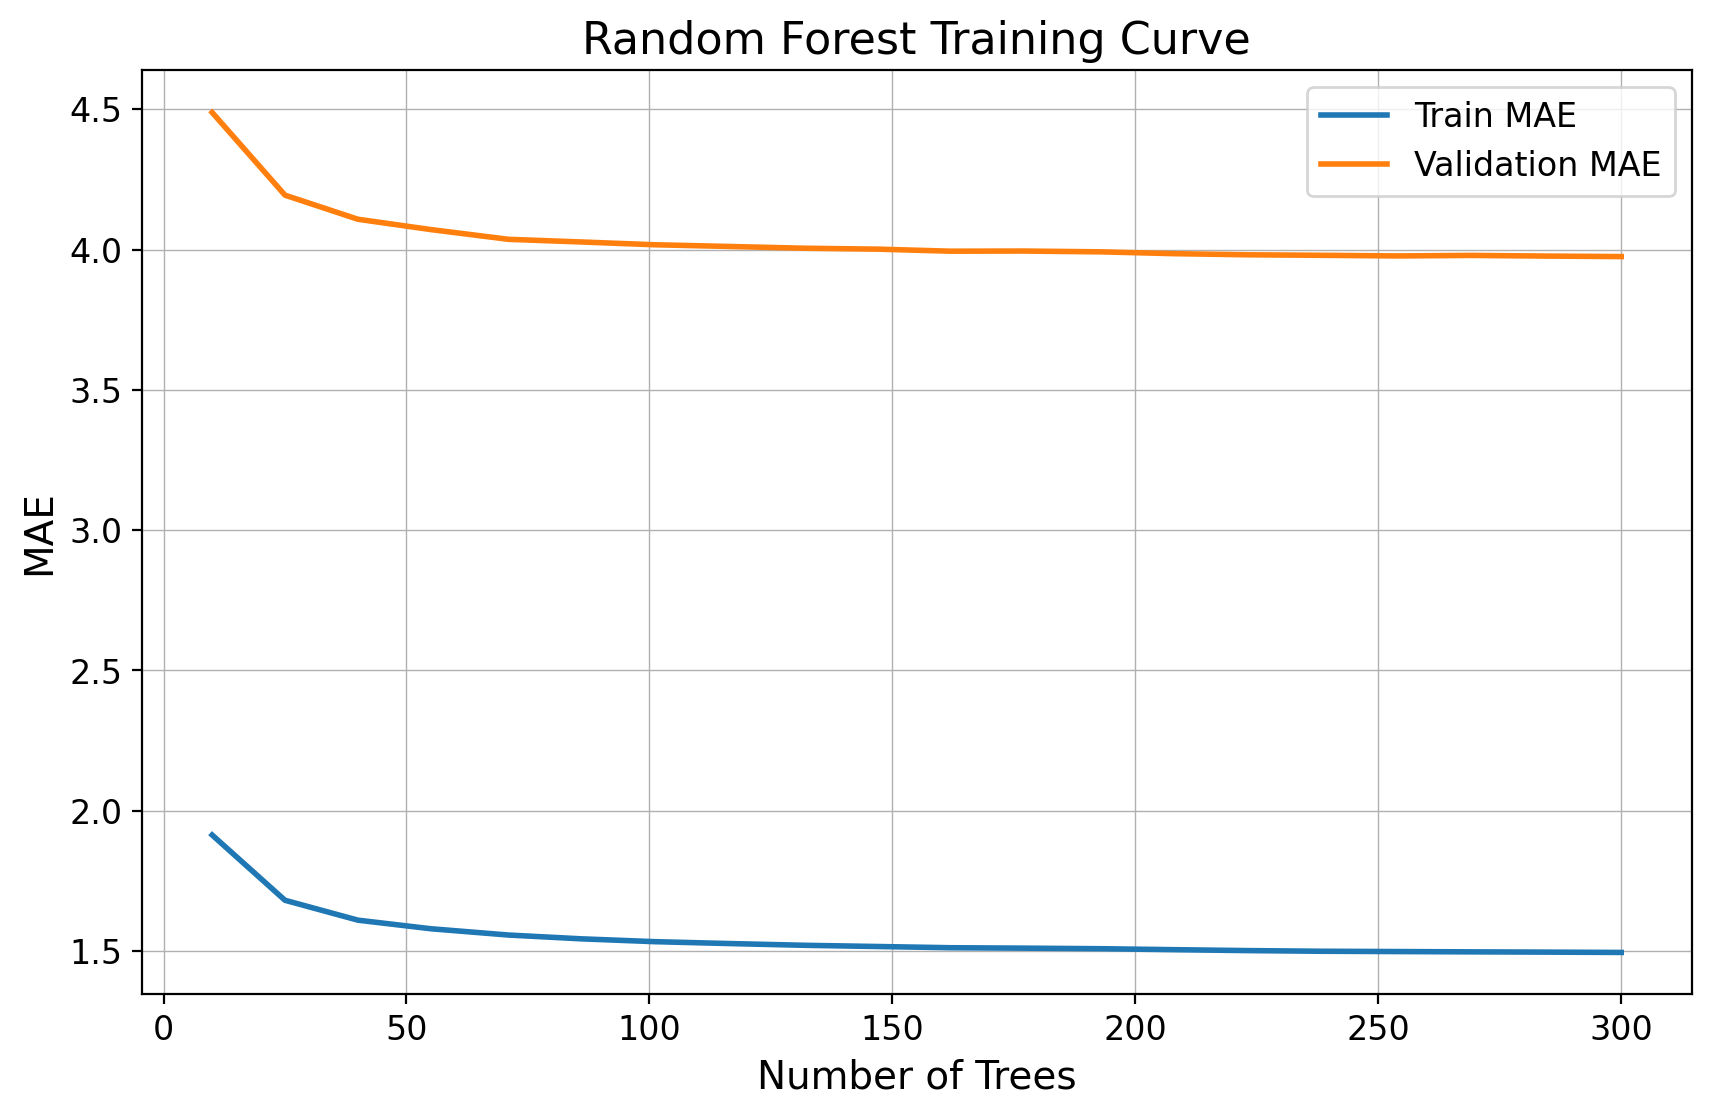


 Training curve saved to: ../results/random_forest_training_curve.png

Εκπαίδευση τελικού μοντέλου στο πλήρες training set...

Αποτελέσματα στο test set:
 R² Score (Ακρίβεια): 0.9971
 RMSE (Σφάλμα):       1.1325 cm
 MAE (Μέσο λάθος):    0.4302
 BIAS (Μεροληψία):    0.0013 cm

 Model saved as: D:/random_forest_model_fast.pkl


In [ ]:
# Compute the training curves graph

x_final = x[selected_features]
print("Training with:\n", x_final.head(1))

target = "lwe_thickness"
extra_features = ["year", "month", "lon_grace", "lat_grace"]

base_features = list(x_final.columns)
features = base_features + extra_features
features = [col for col in features if col != target]

X = merged[features]
y = merged[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Max Data Sample
max_tuning_samples = 100000 #adjust as needed eg 50000

if len(X_train) > max_tuning_samples:
    X_tune = X_train.sample(n=max_tuning_samples, random_state=42)
    y_tune = y_train.loc[X_tune.index]
else:
    X_tune = X_train
    y_tune = y_train

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

kf = KFold(n_splits=3, shuffle=True, random_state=42) 

tuner = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid, 
    n_iter=10,   
    scoring='neg_mean_absolute_error',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\nTuning begins (subset)...")
tuner.fit(X_train_sub, y_train_sub) 
best_params = tuner.best_params_ 
print(f"\nBest Parameters: {best_params}")

max_trees = best_params['n_estimators']
curve_steps = np.unique(
    np.linspace(10, max_trees, num=min(max_trees // 10, 20), dtype=int)
)

rf_curves = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_estimators=1,
    warm_start=True,
    n_jobs=-1
)

train_mae_list = []
val_mae_list = []
current_trees = 0

print("\nComputing learning curves...")
for n_trees in curve_steps:
    rf_curves.n_estimators = int(n_trees)
    rf_curves.fit(X_train_sub, y_train_sub)

    y_train_pred = rf_curves.predict(X_train_sub)
    y_val_pred = rf_curves.predict(X_val)

    train_mae = mean_absolute_error(y_train_sub, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)

    print(f"Trees: {n_trees:4d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")


plt.figure(figsize=(10, 6), dpi=200)
plt.plot(curve_steps, train_mae_list, label='Train MAE', linewidth=2)
plt.plot(curve_steps, val_mae_list, label='Validation MAE', linewidth=2)
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Random Forest Training Curve', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linewidth=0.5)
curve_path = "../results/random_forest_training_curve.png"
plt.savefig(curve_path, dpi=200)
plt.show()
print(f"\n Training curve saved to: {curve_path}")

best_rf = RandomForestRegressor(
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_estimators=best_params['n_estimators'],
    n_jobs=-1
)

print("\nTraining final model on the full training set")
best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print("\nResults on test set:")
print(f" R² Score : {r2:.4f}")
print(f" RMSE :       {rmse:.4f} cm")
print(f" MAE (Mean Absolute Error) :    {mae:.4f}")
print(f" BIAS :    {bias:.4f} cm")

model_path = "../results/random_forest_model.pkl"
joblib.dump(best_rf, model_path)
print(f"\n Model saved as: {model_path}")


 # <font size="4"> Compute training curves </font>

 ΕΚΚΙΝΗΣΗ XGBOOST ANALYSIS 
Η εκπαίδευση του μοντέλου θα γίνει με:
          tp      ssro     swvl3     swvl4  slt
0  0.003832  0.001679  0.455254  0.476822  4.0

 Ξεκινά το Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best Parameters {'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Υπολογισμός learning curves για XGBoost (έως 500 δέντρα)...
Trees:   10 | Train MAE: 7.5813 | Val MAE: 7.7613
Trees:   35 | Train MAE: 1.0565 | Val MAE: 1.6289
Trees:   61 | Train MAE: 0.4934 | Val MAE: 1.1657
Trees:   87 | Train MAE: 0.3542 | Val MAE: 1.0535
Trees:  113 | Train MAE: 0.3059 | Val MAE: 1.0182
Trees:  138 | Train MAE: 0.2710 | Val MAE: 0.9944
Trees:  164 | Train MAE: 0.2467 | Val MAE: 0.9787
Trees:  190 | Train MAE: 0.2275 | Val MAE: 0.9663
Trees:  216 | Train MAE: 0.2125 | Val MAE: 0.9575
Trees:  242 | Train MAE: 0.1976 | Val MAE: 0.9493
Trees:  267 | Train MAE: 0.1873 | Val MAE: 0.9439
Trees:  293 | Tra

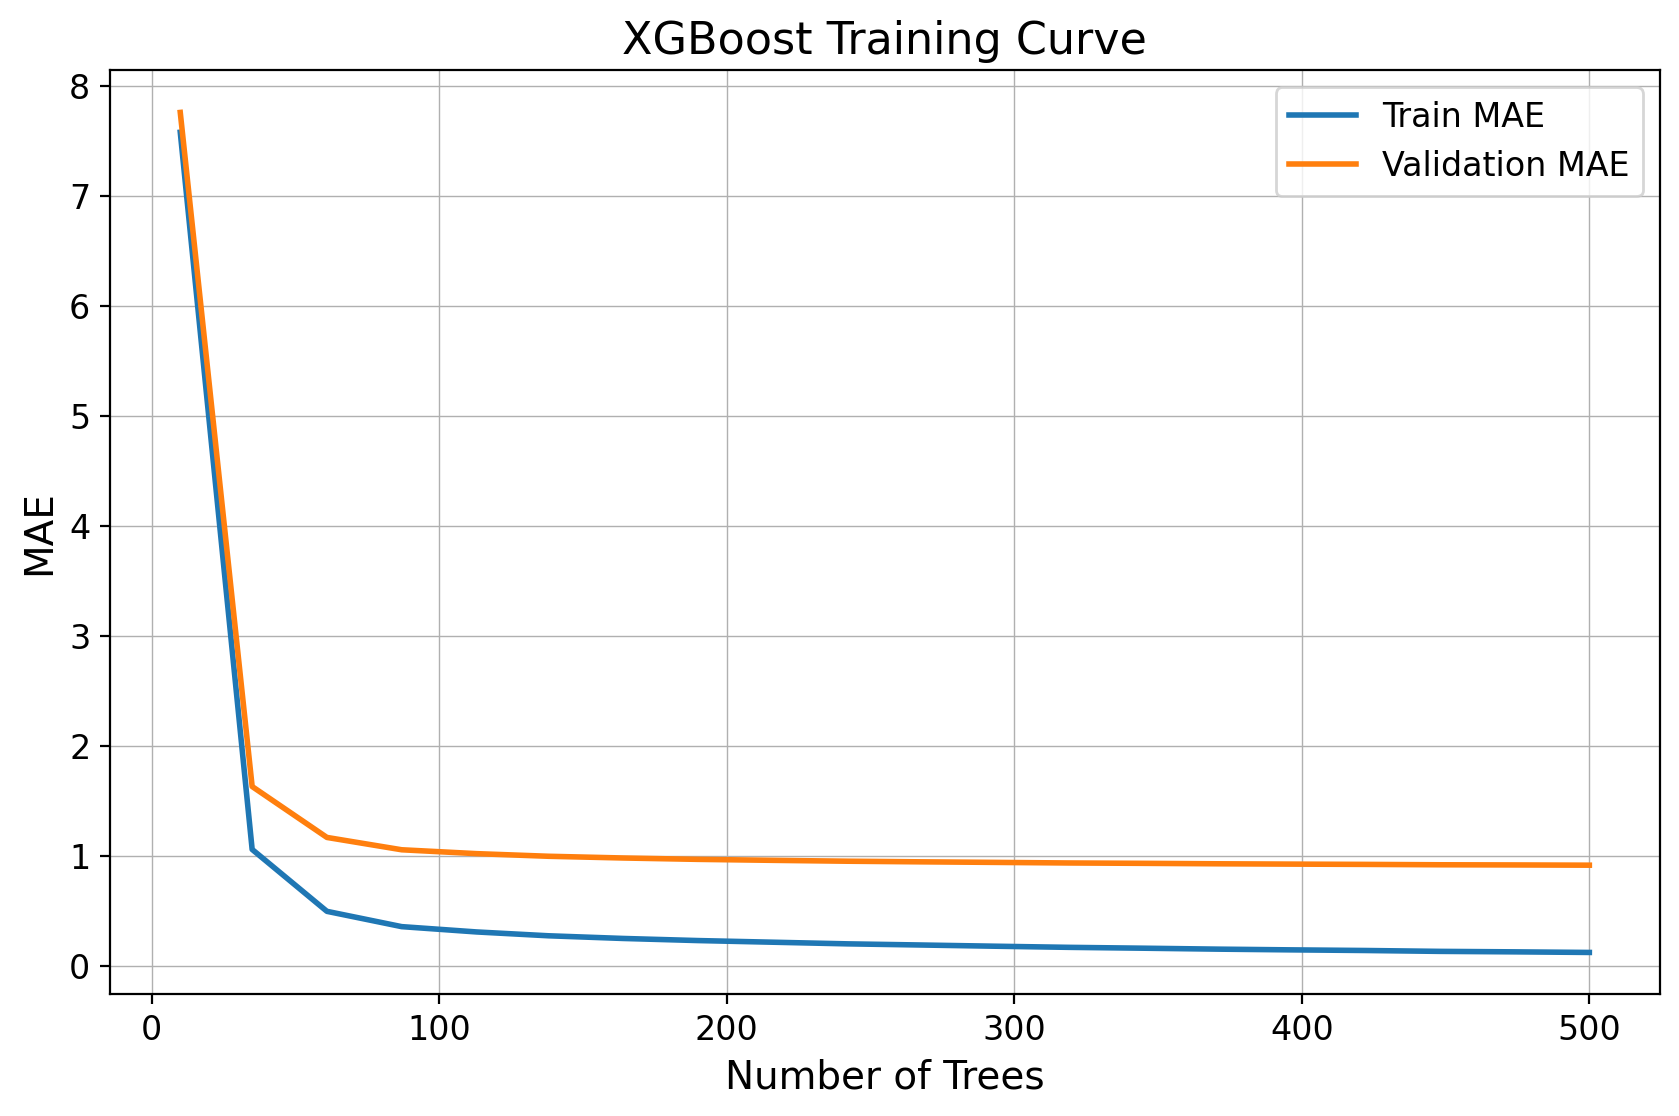

 Το γράφημα αποθηκεύτηκε: C:/Users/akara/OneDrive/Desktop/DE_Karachles/programm/project_ML/results/xgboost_curve.png

 Εκπαίδευση ΤΕΛΙΚΟΥ μοντέλου με 250 δέντρα...

 Αξιολόγηση στο Test Set...
------------------------------
 R² Score (Ακρίβεια): 0.9952
 RMSE (Σφάλμα):       1.6497 cm
 MAE (Μέσο λάθος):    0.7846 cm
 BIAS (Μεροληψία):    0.0066 cm
------------------------------


FileNotFoundError: [Errno 2] No such file or directory: 'D:/XGBoost_model_fast.pkl'

In [ ]:
#XGB_learning curve

print(" Starting XGBoost analysis ")
x_final = x[selected_features]
print("Model training will be performed with features::\n", x_final.head(1))

target = "lwe_thickness"
extra_features = ["year", "month", "lon_grace", "lat_grace"]

base_features = list(x_final.columns)
features = base_features + extra_features
features = [col for col in features if col != target]

X = merged[features]
y = merged[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

max_tuning_samples = 100000 

if len(X_train) > max_tuning_samples:
    print(f" Χρήση δείγματος {max_tuning_samples} για το Tuning...")
    X_tune = X_train.sample(n=max_tuning_samples, random_state=42)
    y_tune = y_train.loc[X_tune.index]
else:
    X_tune = X_train
    y_tune = y_train

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

# Tuning 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)

param_grid = {
    'n_estimators': [100, 200, 500], #500
    'max_depth': [10, 15, 6], 
    'colsample_bytree': [0.7, 0.8, 1], #0.7,0.8,1
    'min_child_weight': [1, 3, 5], 
    'learning_rate': [0.01, 0.05, 0.1] #0.01,0.05,0.1
}

kf = KFold(n_splits=3, shuffle=True, random_state=42) #5

tuner = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,                      
    scoring='neg_mean_absolute_error', 
    cv=kf,                          
    verbose=1,
    n_jobs=1,                      
    random_state=42
)

print("\n Starting Tuning")
tuner.fit(X_train_sub, y_train_sub)
best_params = tuner.best_params_
print(f"\n Best Parameters {best_params}")

# Using optimal number of trees found by Tuning
max_trees = best_params['n_estimators']
curve_steps = np.unique(
    np.linspace(10, max_trees, num=min(max_trees // 10, 20), dtype=int)
)
# Lists for storing results
train_mae_list = []
val_mae_list = []

print(f"\nCalculating learning curves for XGBoost (for {max_trees} trees)")

for n_trees in curve_steps:
    
    # Create a temporary model for this step
    # We use the best_params except n_estimators (which we set manually here)
    # Filter parameters to remove 'n_estimators'
    params_without_n = {k: v for k, v in best_params.items() if k != 'n_estimators'}
    
    xgb_curves = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,             
        n_estimators=int(n_trees), 
        **params_without_n     
    )
    
    # Train on the subset (sub)
    xgb_curves.fit(X_train_sub, y_train_sub)

    # Predictions
    y_train_pred = xgb_curves.predict(X_train_sub)
    y_val_pred = xgb_curves.predict(X_val)

    # Calculating errors
    train_mae = mean_absolute_error(y_train_sub, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)

    print(f"Trees: {n_trees:4d} | Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

# plot
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(curve_steps, train_mae_list, label='Train MAE', linewidth=2)
plt.plot(curve_steps, val_mae_list, label='Validation MAE', linewidth=2)
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('XGBoost Training Curve', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linewidth=0.5)


# Saving plot
curve_path = "../results/XGBoost_training_curve.pkl"
plt.savefig(curve_path, dpi=200)
plt.show()
print(f" Training curve saved to : {curve_path}")

final_n_estimators = 300  

print(f"\n Training final model with {final_n_estimators} trees")

best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    **{k: v for k, v in best_params.items() if k != 'n_estimators'}, 
    n_estimators=final_n_estimators
)

best_xgb.fit(X_train, y_train)

# Evaluation
y_pred = best_xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print("-" * 30)
print(f" R² Score : {r2:.4f}")
print(f" RMSE :       {rmse:.4f} cm")
print(f" MAE (Mean Absolute Error):    {mae:.4f} cm")
print(f" BIAS :    {bias:.4f} cm")
print("-" * 30)

# Saving model

model_path = "../results/XGBoost_model.pkl"
joblib.dump(best_xgb, model_path)
print(f" Model saved to : {model_path}")

# <font size="4"> ERA5 evaporation map </font>

Ετοιμασία χάρτη για τη μεταβλητή 'e' στις 2002-01-01 06:00...


c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


 Raster plot saved as: C:/Users/akara/OneDrive/Desktop/DE_Karachles/programm/project_ML/maps/ERA5_evaporation.jpg


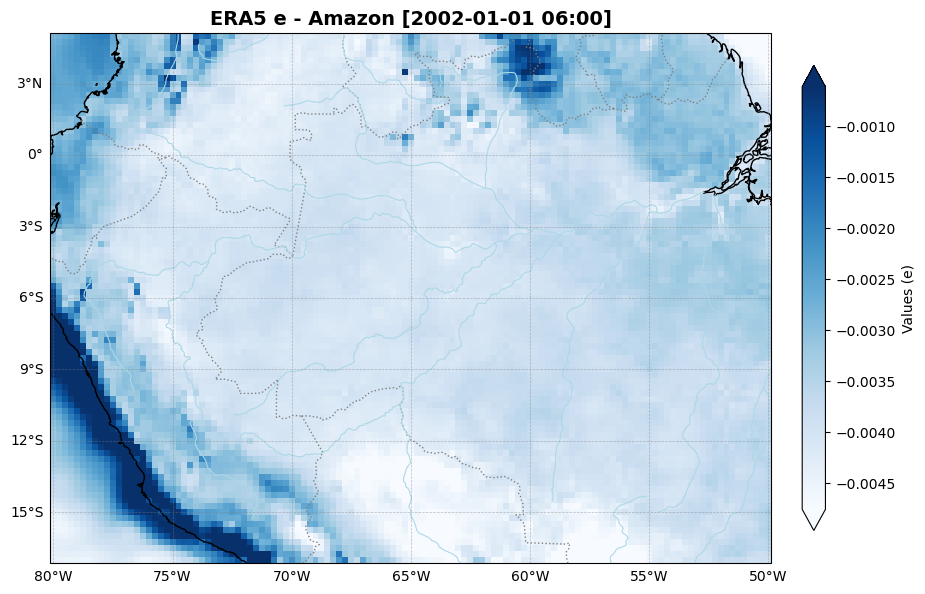

In [ ]:
# evaporation (ERA5_1 dataset)
output_jpg_era5 = "../Maps/ERA5_evaporation.jpg"

var_to_plot = 'e' 
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(" Invalid input! Terminating programm.")
    sys.exit() 

data_slice = ds_era1_sliced[var_to_plot].isel(valid_time=0)

time_str = data_slice.valid_time.dt.strftime("%Y-%m-%d %H:00").item()

print(f"Preparing map for '{var_to_plot}' {time_str}")

plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.PlateCarree())

plot = data_slice.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="Blues",     
    robust=True,      
    cbar_kwargs={     
        "orientation": "vertical",
        "fraction": 0.03,
        "pad": 0.04,
        "label": f"Values ({var_to_plot})" 
    }
)

ax.coastlines(resolution="10m", color="black", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')

ax.add_feature(cfeature.RIVERS, color='lightblue', linewidth=0.8)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False   
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


# Title
ax.set_title(f"ERA5 {var_to_plot.lower()}  [{time_str}]", fontsize=14, fontweight='bold')

# Remove default xarray labels
ax.set_xlabel("")
ax.set_ylabel("")

plt.savefig(output_jpg_era5, dpi=300, bbox_inches="tight")
print(f" Raster plot saved as: {output_jpg_era5}")

plt.show()

# <font size="4"> Comparison: Actual and Predicted GRACE Maps </font>

 Φόρτωση μοντέλου από: ../models/rf_5features.pkl


c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as

 Ο χάρτης αποθηκεύτηκε: ../results/Grace_Actual_vs_Predicted.jpg


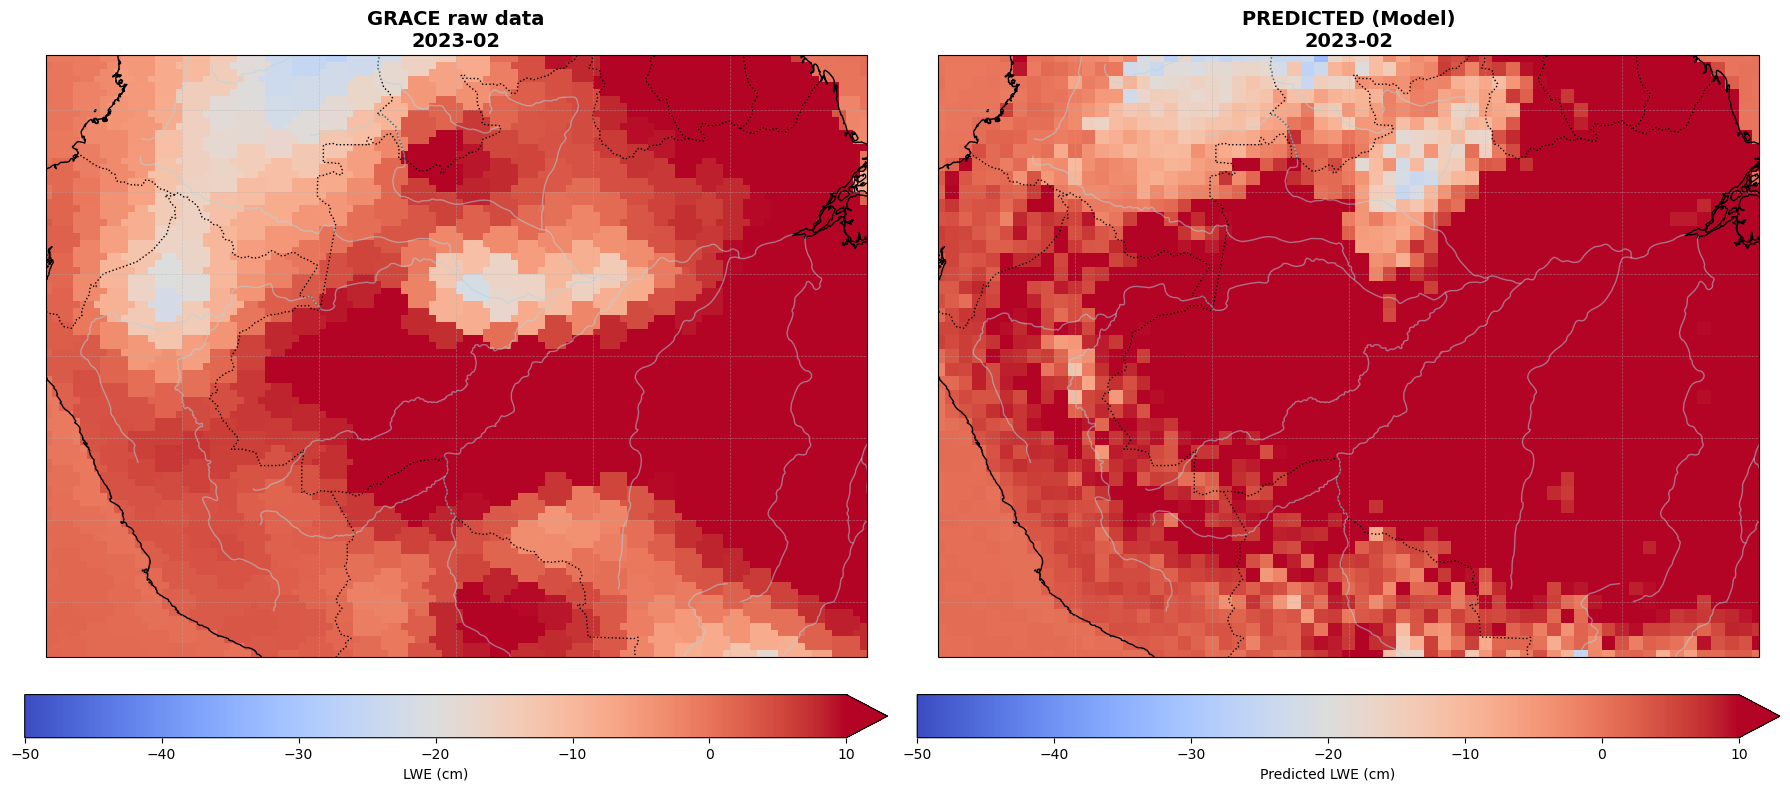

In [ ]:
# Maps_4
# Subplot raw-predict
output_jpg_sub = "../results/Grace_Actual_vs_Predicted.jpg"
model_path = "../models/rf_5features.pkl"

var_to_plot = 'lwe_thickness'

# input date
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(" Invalid input! Terminating programm.")
    sys.exit() 

# Load model
print(f" Loading model from: {model_path}")
try:
    model = joblib.load(model_path)
except FileNotFoundError:
    print("Error: .pkl file was not found!!")
    sys.exit()


# Grace raw data
target_date = f"{map_year}-{map_month:02d}" # :02d ensures 2 digits (e.g., 8 becomes 08)
try:
    data_actual = ds_grace_sliced[var_to_plot].sel(time=target_date, method='nearest')
    time_str = data_actual.time.dt.strftime("%Y-%m").item()
except KeyError:
    print(f" Error: Grace data not found for {map_month}/{map_year}")
    sys.exit()

# Grace data after prediction
input_data = merged[(merged['year'] == map_year) & (merged['month'] == map_month)].copy()

if input_data.empty:
    print(f" Error: ERA5 data not found for {map_month}/{map_year}.")
    sys.exit()
else:
    #  features
    try:
        required_features = model.feature_names_in_
    except AttributeError:
        print("Τα δεδομένα δεν βρέθηκαν στο μοντέλο χρησιμοποιώ τα default")
        required_features = features 
    
    # Prediction
    X_pred = input_data[required_features]
    input_data['lwe_pred'] = model.predict(X_pred)
    
    ds_pred = input_data.groupby(['lat_grace', 'lon_grace'])[['lwe_pred']].mean().to_xarray()
    data_predicted = ds_pred['lwe_pred']

# Subplot: (ax1: Grace_raw, ax2:Grace_pred)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

#Μap_1
data_actual.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm", 
    robust=True,
    cbar_kwargs={"label": "LWE (cm)", "orientation": "horizontal", "pad": 0.05},
    vmin= -50,vmax= +10
)
ax1.set_title(f"GRACE raw data\n{time_str}", fontsize=14, fontweight='bold')
ax1.coastlines(resolution="10m")
ax1.add_feature(cfeature.BORDERS, linestyle=":")
ax1.add_feature(cfeature.RIVERS, color='lightblue', alpha=0.5)
ax1.gridlines(draw_labels=False, linewidth=0.5, linestyle='--', alpha=0.5)

# Map_2
data_predicted.plot.pcolormesh(
    ax=ax2,
    transform=ccrs.PlateCarree(), 
    cmap="coolwarm", 
    robust=True,
    cbar_kwargs={"label": "Predicted LWE (cm)", "orientation": "horizontal", "pad": 0.05},
    vmin= -50,vmax= +10
)
ax2.set_title(f"PREDICTED (Model)\n{time_str}", fontsize=14, fontweight='bold')
ax2.coastlines(resolution="10m")
ax2.add_feature(cfeature.BORDERS, linestyle=":")
ax2.add_feature(cfeature.RIVERS, color='lightblue', alpha=0.5)
ax2.gridlines(draw_labels=False, linewidth=0.5, linestyle='--', alpha=0.5)

# Save
plt.tight_layout()
plt.savefig(output_jpg_sub, dpi=300, bbox_inches="tight")
print(f" Map saved to: {output_jpg_sub}")

plt.show()